In [60]:
import random
import numpy as np
import matplotlib
import sys
import numba
from tqdm.notebook import tqdm
import time
import multiprocessing as mp
from numba import jit, prange
from numba import config, njit, threading_layer
from matplotlib import pyplot as plt

### NOTEBOOK 2
### Indhold: 
Udvidet Prisoner's dilemma Tilføjet Nuke mulighed \
Almindelig Q-learner, master Q-learner \
Tilføjet master-theta eller epsilon, ændring over generationer

In [61]:

@njit
def master_q_player(prices, Q, epsilon, p2,t):
    if random.uniform(0,1) < epsilon:
        p3 = int(np.random.choice(len(prices)))
        #print('now its random', epsilon)
    else:
        #p3, pyt = np.unravel_index(np.argmax(Q),Q.shape)
        p3 = int(np.argmax(Q[:,p2]))
    return p3

In [62]:
@njit
def npc_player_gen2(options, q_table, epsilon, prev, time):
    if prev[time-2] ==0 and prev[time-1]==0 and prev[time]==0:
        npc_choice = 1
    elif prev[time] == 1:
        npc_choice = 0
    else:
        npc_choice = prev[time]

    return npc_choice

In [63]:
random.uniform(0,1)

0.555974197176084

In [64]:
@njit
def npc_master_opponent(options, q_table, my_choice, their_choice, q_counter, npc_counter, nukecounter):
    if nukecounter <= 400: 
        if my_choice[npc_counter-1] == 1 and their_choice[q_counter-1]==2: 
            nukecounter = nukecounter + 1
            #print("adding a nuke counter", nukecounter)
            if random.uniform(0,1) < (1 - (nukecounter / 400)):
                npc_choice = 1
            else:
                npc_choice = 0
        else:
            npc_choice = int(np.random.choice(len(options)))
            
    else: 
        npc_choice = 0
    
    return int(npc_choice), int(nukecounter)

In [65]:
#random.seed(1235)
#Demand function from Klein (2020)
@njit
def PD_rewards(p1,p2):
    x = np.array(
            [[(12,12), (0,13), (-12,-12)],
            [(13,0), (1,1), (-12,-12)],
             [(-12,-12), (-12,-12), (-12,-12)]]
             )
    val_p1, val_p2 = x[p1,p2]
    
    return val_p1, val_p2
        

In [66]:
PD_rewards(1,0)[0]

13

In [67]:
PD_rewards(1,0)[1]

0

In [73]:
def moving_avg(fst_arr, snd_arr, window_size):

    moving_averages = []
    moving_averages2 = []
    i = 0
    while i < len(fst_arr) - window_size + 1:
    
        # Calculate the average of current window
        window_average = np.sum(fst_arr[
        i:i+window_size]) / window_size
        window_average2 = np.sum(snd_arr[
        i:i+window_size]) / window_size
        
        # Store the average of current
        # window in moving average list
        moving_averages.append(window_average)
        moving_averages2.append(window_average2)

        
        # Shift window to right by one position
        i += 1
    return moving_averages, moving_averages2

def prof_means(prof_arr1, prof_arr2):
    return np.mean(prof_arr1, axis=0), np.mean(prof_arr2, axis=0)

In [68]:
@njit
def regular_update(Q, prev, alpha, delta, prices, indic):
     if indic == 1: 
         p1 = prev[0,0]
         p2 = prev[1,0]
         p22 = prev[1,1]
         pe1 = Q[prev[0,0],prev[1,0]]
         ne1 = PD_rewards(p1,p2)[0] + delta* PD_rewards(p1,p22)[0] + delta**2 * Q[np.argmax(Q[:,prev[1,1]]),prev[1,1]]
         Q[prev[0,0], prev[1,0]] = (1-alpha) * pe1 + alpha * ne1
         #print('GAME player 1 ne and pe', ne1, pe1)
     else: 
        p1 = prev[1,0]
        p2 = prev[0,0]
        p22 = prev[0,1]
        pe2 = Q[prev[1,0],prev[0,0]]
        ne2 = PD_rewards(p2,p1)[1] + delta* PD_rewards(p22,p1)[1] + delta**2 * Q[np.argmax(Q[:,prev[0,1]]),prev[0,1]]
        Q[prev[1,0], prev[0,0]] = (1-alpha) * pe2 + alpha * ne2

@njit
def simple_Q_learner(prices, Q, epsilon, p2):
    if random.uniform(0,1) < epsilon:
        p3 = int(np.random.choice(len(prices)))
        #print('now its random', epsilon)
    else:
        #p3, pyt = np.unravel_index(np.argmax(Q),Q.shape)
        p3 = int(np.argmax(Q[:,p2]))
    return p3

In [69]:

@njit
def update(Q, prev, alpha, delta, prices, Current_t, previous_t, time, interval):
        my_old_price = prev[0,0]
        their_old_price = prev[1,0]
        their_new_choice = prev[1,1]
        intervals = np.shape(Q)[0]
        

        prev_interval = max(0,Current_t-1)
        next_interval = min(intervals-1, Current_t+1)
        w_1 =  ( next_interval - time/interval) / (next_interval - prev_interval)
        w_2 =  (time/interval - prev_interval) / (next_interval - prev_interval) 
        # Current_Q_Table = Q[previous_t]*w_2 + Q[Current_t]*w_1
        
        # prev_q_est = Current_Q_Table[prev[0,0],prev[1,0]]
        # new_q_est = PD_rewards(my_old_price,their_old_price)[0] + delta* PD_rewards(my_old_price,their_new_choice)[0] + delta ** 2 * Current_Q_Table[np.argmax(Current_Q_Table[:,prev[1,1]]),prev[1,1]]
        # Q[previous_t, prev[0,0], prev[1,0]] = (1-alpha) * prev_q_est + w_2 * (alpha * (new_q_est))
        # Q[Current_t, prev[0,0], prev[1,0]] = (1-alpha) * prev_q_est + w_1 * (alpha * (new_q_est))
        prev_q_est_1 = Q[prev_interval, prev[0,0],prev[1,0]]
        prev_q_est_2 = Q[next_interval, prev[0,0],prev[1,0]]
        new_q_est_prev = PD_rewards(my_old_price,their_old_price)[0] + delta* PD_rewards(my_old_price,their_new_choice)[0] + delta ** 2 * Q[prev_interval,np.argmax(Q[prev_interval,:,prev[1,1]]),prev[1,1]]
        new_q_est_next = PD_rewards(my_old_price,their_old_price)[0] + delta* PD_rewards(my_old_price,their_new_choice)[0] + delta ** 2 * Q[next_interval,np.argmax(Q[next_interval,:,prev[1,1]]),prev[1,1]]
        
        Q[prev_interval, prev[0,0], prev[1,0]] = (1-alpha*w_2)*prev_q_est_1 + (alpha*w_2)*new_q_est_prev
        Q[next_interval, prev[0,0], prev[1,0]] = (1-alpha*w_1)*prev_q_est_2 + (alpha*w_1)*new_q_est_next
        # if time > 37700 and time % 201==0:
        #         print("time: ", time, "prev_q_est_1", prev_q_est_1, "prev_q_est_2", prev_q_est_2, "new_q_est_prev", new_q_est_prev, "new_q_est_next", new_q_est_next,"updating:", Q[prev_interval, prev[0,0], prev[1,0]], "with ", (1-alpha*w_2)*prev_q_est_1 + (alpha*w_2)*new_q_est_prev, "#2 Updating",Q[next_interval, prev[0,0], prev[1,0]], "With:", (1-alpha*w_1)*prev_q_est_2 + (alpha*w_1)*new_q_est_next )



In [107]:
@njit
def PD_game(q_table, options, periods, alpha, theta, delta, master_theta):
    a = len(options)
    Simple_Q_Table = np.zeros((a, a))
    Simple_Q_Table2 = np.zeros((a, a))
    interval_size = periods/20
    nukecounter = 0
    prev_choices = np.zeros((2,2), dtype=numba.int64)
    for i in range(2):
        for j in range(2):
            prev_choices[i,j] = int(np.random.choice(len(options))) 
    
    reward_arr = np.zeros(int(periods-2))
    reward_arr_p2 = np.zeros(int(periods-2))
    all_choices1 =np.zeros(int(periods/2)-1)
    all_choices2 =np.zeros(int(periods/2)-1)
    i_counter = 0
    j_counter = 0
    t=3
    if np.shape(q_table) != (20,a,a):
        print("Wrong dimensions")
    else:
        for t in range(t, periods+1):
        
            epsilon = (1-theta)**t
            #master_epsilon = (1-master_theta)**t
            master_epsilon = master_theta
            if t % 2 != 0: 
                time_for_q = int(np.floor(t/interval_size))
                prev_time_for_q = int(np.floor((t-1)/interval_size))
                #print("TimeCHeck",time_for_q,time_for_q)
                #print('time for q', time_for_q, 'prev time for q', prev_time_for_q, "prev", prev_choices)
                
                update(q_table, prev_choices, alpha, delta, options, time_for_q, prev_time_for_q, t, interval_size)
                prev_interval = max(0,time_for_q-1)
                next_interval = min(np.shape(q_table)[0]-1, time_for_q+1)
                w_1 =  ( next_interval - t/interval_size) / (next_interval - prev_interval)
                w_2 =  (t/interval_size - prev_interval) / (next_interval - prev_interval) 
                Current_Q_Table = q_table[prev_time_for_q]*w_2 + q_table[time_for_q]*w_1 
                p_i = master_q_player(options, Current_Q_Table, master_epsilon, prev_choices[1,1], time_for_q)
                fst_player = "Master Q"
                
                #regular_update(Simple_Q_Table, prev_choices, alpha, delta, options, 1)
                #p_i = simple_Q_learner(options, Simple_Q_Table, epsilon, prev_choices[1,1])
                #fst_player = "Q-learner"

                prev_choices[0,0] = prev_choices[0,1]
                prev_choices[0,1] = p_i
                prev_choices[1,0] = prev_choices[1,1]
                all_choices1[i_counter] = (options[p_i])
                i_counter += 1
                #print('Spiller 1 tur: p:', prices[p_i],' p_j: ', prices[prev_p[1,1]],'iteration:', t,'Q_table: \n', Q_table)
                reward_arr[t-3], reward_arr_p2[t-3] = PD_rewards(prev_choices[0,1], prev_choices[1,1])
            else: 

                #regular_update(Simple_Q_Table2, prev_choices, alpha, delta, options, 2)
                #p_j = simple_Q_learner(options, Simple_Q_Table2, epsilon, prev_choices[0,1])
                #snd_player = "Q-learner"
                
                
                p_j, nukecounter = npc_master_opponent(options, q_table, all_choices2, all_choices1, i_counter, j_counter, nukecounter)
                snd_player = "nuke2stop"

                # p_j= npc_player_gen2(options, q_table, 0, all_choices1, all_choices2, j_counter)
                # snd_player = "3C -> D"

                prev_choices[1,0] = prev_choices[1,1]
                prev_choices[1,1] = p_j
                prev_choices[0,0] = prev_choices[0,1]
                all_choices2[j_counter] = (options[p_j])
                j_counter += 1
                #print('Spiller 2 tur: p:', prices[p_j], 'p_i', prices[prev_p[0,1]],' iteration: ', t,'Q_table2: \n', Q_table2)
                reward_arr[t-3], reward_arr_p2[t-3] = PD_rewards(prev_choices[0,1], prev_choices[1,1])
                #step_counter +=1
    return all_choices1, all_choices2, reward_arr, reward_arr_p2, q_table, Simple_Q_Table, Simple_Q_Table2, fst_player, snd_player





    
    

In [108]:
def many_games(prices, periods, alpha, theta, learners, delta, init_q):
    total_pro_arr = np.zeros((learners,periods-2),dtype=np.ndarray)
    total_pro_arr2 = np.zeros((learners,periods-2),dtype=np.ndarray)
    total_opt_arr = np.zeros((learners, 49), dtype = np.ndarray)
    avg_profit = np.zeros(learners)
    avg_profit2 = np.zeros(learners)
    change_arr = np.zeros((1,25))
    change_arr2 = np.zeros((1,25))
    CC_arr = np.zeros((learners,15))
    print(f"running {learners} learners, each for {periods} periods")

    for i in range(learners):
        
        if i % (learners // 10) == 0:
            progress = (i / learners) * 100
            print(f"Progress: {progress:.0f}% done")
         

        #master_theta = theta
        #master_theta = 0.087988
        #master_epsilon= (1-master_theta)**i
        #master_theta = theta*((i**1.01)/learners)
        master_theta = (1-0.00916806)**i
        all_choices1, all_choices2, reward_arr, reward_arr_p2, q_table, q_table_simple, q_simp2, fst_player, snd_player= PD_game(init_q, prices, periods, alpha, theta, delta, master_theta)
        total_pro_arr[i] = reward_arr
        total_pro_arr2[i] = reward_arr_p2
        #total_opt_arr[i] = arr_opt_i
        avg_profit[i] = np.mean(reward_arr[-10000:])
        avg_profit2[i] = np.mean(reward_arr_p2[-10000:])
        for t in range(15):
            CC_arr[i,t] = q_table[t,2,1]
        init_Q = q_table
        
    return total_pro_arr, total_pro_arr2, avg_profit, avg_profit2, init_Q, q_table_simple, all_choices1, all_choices2, CC_arr, q_simp2, fst_player, snd_player

In [109]:
options = np.array([0,1,2])
init_Q = np.zeros((20,3,3))
#100.000 theta: 0.0000922
#Another Theta: 0.00009199
# 20.000 periods theta: 0.00046041
#40.000 periods, 

learners = 1000
local_periods = 40000
theta= 0.0002302
window = 1000
delta = 0.95

#player options:
rewards_p1, rewards_p2, avg_prof, avg_prof2, final_Q, simple_q, choices1, choices2, CC_arr, q_simp2, player_1, player_2 = many_games(options, local_periods, 0.3, theta, learners , delta, init_Q)

running 1000 learners, each for 40000 periods
Progress: 0% done
Progress: 10% done
Progress: 20% done
Progress: 30% done
Progress: 40% done
Progress: 50% done
Progress: 60% done
Progress: 70% done
Progress: 80% done
Progress: 90% done


In [110]:
samlet_prof, samlet_prof2 = prof_means(rewards_p1, rewards_p2)
profitability_arr, profitability_arr2 = moving_avg(samlet_prof, samlet_prof2, window)


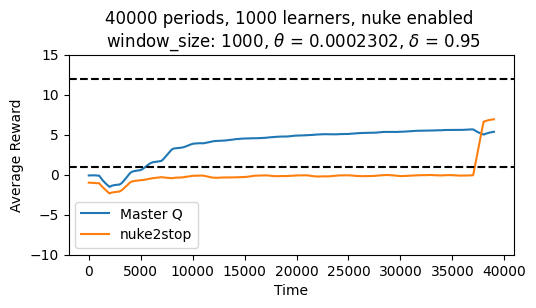

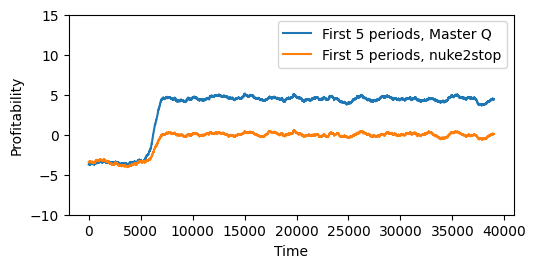

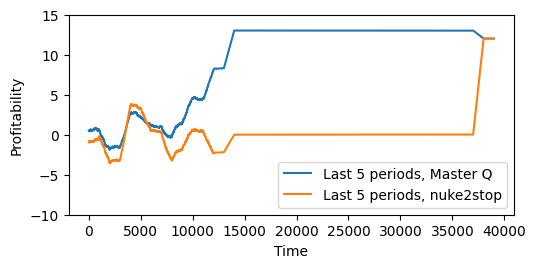

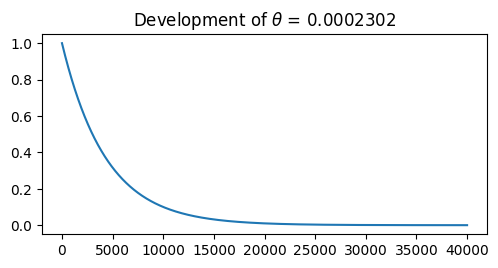

In [111]:
t_arr1 = np.arange(0,local_periods-window-1)
t_arr2 = np.arange(0,local_periods-window-1)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_arr,'-',label=f"{player_1}")
plt.plot(t_arr2,profitability_arr2,'-', label=fr"{player_2}")
plt.title(f"{local_periods} periods, {learners} learners, nuke enabled \n window_size: {window}, $\\theta$ = {theta}, $\\delta$ = {delta} ")
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Average Reward")
plt.axhline(y=12, color='k', linestyle = '--')
plt.axhline(y=1, color='k', linestyle = '--')
plt.ylim(-10,15)
plt.legend()
plt.show()

first_fivep1 = rewards_p1[0:5,:]
first_fivep2 = rewards_p2[0:5,:]

last_fivep1 = rewards_p1[-5:,:]
last_fivep2 = rewards_p2[-5:,:]

first_prof1_5, first_prof2_5 = prof_means(first_fivep1, first_fivep2)
last_prof1_5, last_prof2_5 = prof_means(last_fivep1, last_fivep2)

profitability_first1_5, profitability_first2_5 = moving_avg(first_prof1_5, first_prof2_5, window)
t_arr1 = np.arange(0,local_periods - window-1)
t_arr2 = np.arange(0,local_periods - window-1)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_first1_5,'-',label=f'First 5 periods, {player_1}')
plt.plot(t_arr2,profitability_first2_5,'-', label=f'First 5 periods, {player_2}')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
plt.ylim(-10,15)
plt.legend()
plt.show()

profitability_last1_5, profitability_last2_5 = moving_avg(last_prof1_5, last_prof2_5, window)
t_arr1 = np.arange(0,local_periods - window-1)
t_arr2 = np.arange(0,local_periods - window-1)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_last1_5,'-',label=f'Last 5 periods, {player_1}')
plt.plot(t_arr2,profitability_last2_5,'-', label=f'Last 5 periods, {player_2}')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
plt.ylim(-10,15)
plt.legend()
plt.show()

arr = np.zeros(local_periods)
t = np.arange(0,local_periods,1)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
for i in range(local_periods):
    arr[i] = epsilon = (1-theta)**i

plt.plot(t,arr,'-',label='generational Q_learner')

plt.title(f"Development of $\\theta$ = {theta}")
plt.show()


In [112]:
np.shape(rewards_p1)

(1000, 39998)

In [292]:
print(choices1[20:])
print(choices2[20:])

[1. 0. 0. ... 0. 0. 0.]
[0. 2. 0. ... 1. 1. 1.]


In [293]:
first_fivep1 = rewards_p1[0:5,:]
first_fivep2 = rewards_p2[0:5,:]

last_fivep1 = rewards_p1[-5:,:]
last_fivep2 = rewards_p2[-5:,:]

In [294]:
first_prof1_5, first_prof2_5 = prof_means(first_fivep1, first_fivep2)
last_prof1_5, last_prof2_5 = prof_means(last_fivep1, last_fivep2)

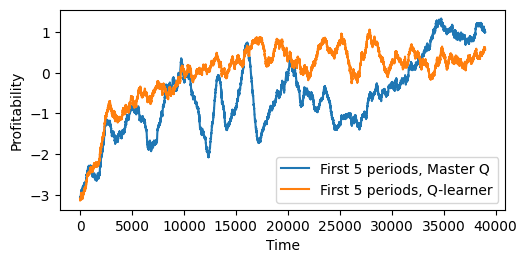

In [295]:
profitability_first1_5, profitability_first2_5 = moving_avg(first_prof1_5, first_prof2_5, window)
t_arr1 = np.arange(0,local_periods - window-1)
t_arr2 = np.arange(0,local_periods - window-1)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_first1_5,'-',label='First 5 periods, Master Q')
plt.plot(t_arr2,profitability_first2_5,'-', label='First 5 periods, Q-learner')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
#plt.ylim(0,5)
plt.legend()
plt.show()

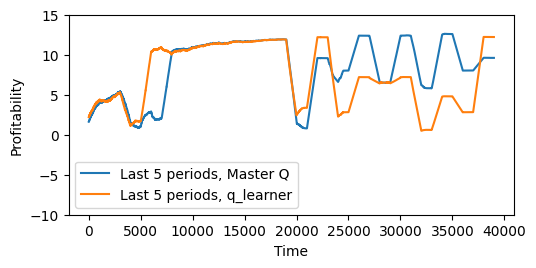

In [296]:
profitability_last1_5, profitability_last2_5 = moving_avg(last_prof1_5, last_prof2_5, window)
t_arr1 = np.arange(0,local_periods - window-1)
t_arr2 = np.arange(0,local_periods - window-1)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_last1_5,'-',label='Last 5 periods, Master Q')
plt.plot(t_arr2,profitability_last2_5,'-', label='Last 5 periods, q_learner')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
plt.ylim(-10,15)
plt.legend()
plt.show()

In [265]:
first_prof1_5, first_prof2_5 = prof_means(first_fivep1, first_fivep2)
last_prof1_5, last_prof2_5 = prof_means(last_fivep1, last_fivep2)

ValueError: x and y must have same first dimension, but have shapes (98999,) and (38999,)

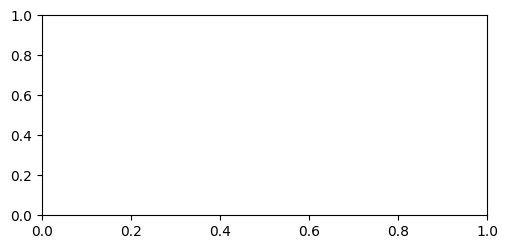

In [231]:
samlet_prof, samlet_prof2 = prof_means(rewards_p1, rewards_p2)

profitability_arr, profitability_arr2 = moving_avg(samlet_prof, samlet_prof2, 1000)
avg_timend = time.time()
#print('ending moving average. time: ', (avg_timend - avgtime))
#np.savetxt("<file>.csv", moving_averages, delimiter = ',')
#print(moving_averages)

t_arr1 = np.arange(0,98999)
t_arr2 = np.arange(0,98999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_arr,'-',label='generational Q_learner')
plt.plot(t_arr2,profitability_arr2,'-', label='Regular old Q player')
plt.axhline(y=3, color='k', linestyle = '--', label='Fully collusive')
plt.axhline(y=1, color='k', linestyle = '--', label='Nash eq.')
plt.xlabel("Time")
plt.ylabel("Avg. reward")
plt.ylim(0,5)
plt.legend()
plt.show()

In [ ]:
arr = np.transpose(CC_arr)
t = np.arange(0,100,1)

arr.shape
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t,arr[0],'-',label='Første C,C')
plt.plot(t,arr[14],'-', label='Anden C,C')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Learners")
plt.ylabel("Q-værdi")
#plt.axhline(y=3, color='k', linestyle = '--')
#plt.axhline(y=, color='k', linestyle = '--')
#plt.ylim(-2,5)
plt.legend()
plt.show()

# EXPERIMENTS WITH LONGER PERIODS #

In [95]:
options = np.array([0,1,2])
init_Q = np.zeros((15,3,3))
#200.000 periods: 
local_periods = 300000
learners = 200
#theta = 0.00004605
rewards_p1, rewards_p2, avg_prof, avg_prof2, final_Q2, bla, choices1, choices2, bla, bla = many_games(options, local_periods, 0.3, 0.00009199, learners ,0.95, final_Q)
final_Q2

run # 1 of  200 runs
run # 2 of  200 runs
run # 3 of  200 runs
run # 4 of  200 runs
run # 5 of  200 runs
run # 6 of  200 runs
run # 7 of  200 runs
run # 8 of  200 runs
run # 9 of  200 runs
run # 10 of  200 runs
run # 11 of  200 runs
run # 12 of  200 runs
run # 13 of  200 runs
run # 14 of  200 runs
run # 15 of  200 runs
run # 16 of  200 runs
run # 17 of  200 runs
run # 18 of  200 runs
run # 19 of  200 runs
run # 20 of  200 runs
run # 21 of  200 runs
run # 22 of  200 runs
run # 23 of  200 runs
run # 24 of  200 runs
run # 25 of  200 runs
run # 26 of  200 runs
run # 27 of  200 runs
run # 28 of  200 runs
run # 29 of  200 runs
run # 30 of  200 runs
run # 31 of  200 runs
run # 32 of  200 runs
run # 33 of  200 runs
run # 34 of  200 runs
run # 35 of  200 runs
run # 36 of  200 runs
run # 37 of  200 runs
run # 38 of  200 runs
run # 39 of  200 runs
run # 40 of  200 runs
run # 41 of  200 runs
run # 42 of  200 runs
run # 43 of  200 runs
run # 44 of  200 runs
run # 45 of  200 runs
run # 46 of  200 ru

array([[[ 7.23197906e+00,  4.91384169e+00, -5.36749982e-01],
        [ 1.20730613e+01,  1.53012318e+00, -7.40176221e+00],
        [ 4.01083024e+00, -8.57775066e-01, -8.93693366e+00]],

       [[ 5.89888394e+01,  2.31658786e+01,  3.38978456e+01],
        [ 2.83421391e+01,  5.39842210e+01,  7.92767845e+00],
        [ 1.81895092e+01,  5.33330996e+00,  3.87831190e+00]],

       [[ 5.99627201e+01,  2.03096814e+01,  3.56233645e+01],
        [ 3.72772318e+01,  5.62634204e+01, -1.05710631e+01],
        [ 1.87392699e+01, -1.05590631e+00, -1.37537721e+01]],

       [[ 6.00000000e+01,  1.38236004e+00,  3.51363377e+01],
        [ 2.55286311e+01,  3.55761122e+01, -1.88060997e+01],
        [ 8.08414287e+00, -1.57067214e+01, -1.54574485e+01]],

       [[ 6.00000000e+01,  2.70782330e+01,  3.00334639e+01],
        [ 2.15255689e+01, -3.18419793e-01, -1.66519285e+01],
        [ 1.20725249e+01, -1.19291354e+01, -1.60495289e+01]],

       [[ 6.00000000e+01,  1.16972062e-04,  2.13804341e+01],
        [ 3.58

In [96]:
samlet_prof, samlet_prof2 = prof_means(rewards_p1, rewards_p2)

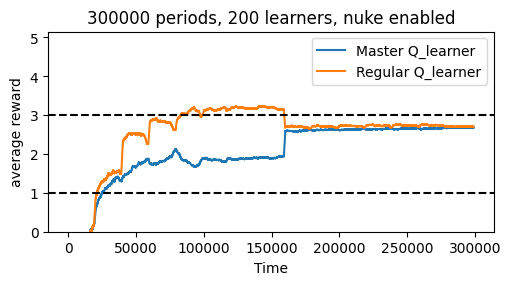

In [98]:

profitability_arr, profitability_arr2 = moving_avg(samlet_prof, samlet_prof2, 1000)
avg_timend = time.time()
#print('ending moving average. time: ', (avg_timend - avgtime))
#np.savetxt("<file>.csv", moving_averages, delimiter = ',')
#print(moving_averages)

t_arr1 = np.arange(0,298999)
t_arr2 = np.arange(0,298999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_arr,'-',label='Master Q_learner')
plt.plot(t_arr2,profitability_arr2,'-', label='Regular Q_learner')
plt.title(f"{local_periods} periods, {learners} learners, nuke enabled")
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("average reward")
plt.axhline(y=3, color='k', linestyle = '--')
plt.axhline(y=1, color='k', linestyle = '--')
plt.ylim(0,5.15)
plt.legend()
plt.show()

In [99]:
first_fivep1 = rewards_p1[0:10,:]
first_fivep2 = rewards_p2[0:10,:]

last_fivep1 = rewards_p1[-20:,:]
last_fivep2 = rewards_p2[-20:,:]

In [100]:
first_prof1_5, first_prof2_5 = prof_means(first_fivep1, first_fivep2)
last_prof1_5, last_prof2_5 = prof_means(last_fivep1, last_fivep2)

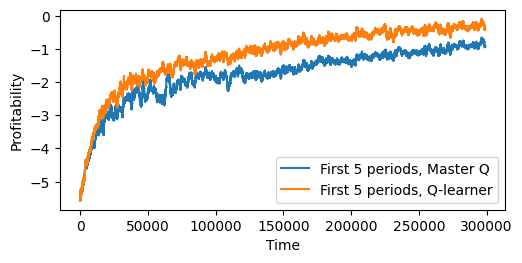

In [102]:
profitability_first1_5, profitability_first2_5 = moving_avg(first_prof1_5, first_prof2_5, 1000)
t_arr1 = np.arange(0,298999)
t_arr2 = np.arange(0,298999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_first1_5,'-',label='First 5 periods, Master Q')
plt.plot(t_arr2,profitability_first2_5,'-', label='First 5 periods, Q-learner')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
#plt.ylim(0,5)
plt.legend()
plt.show()

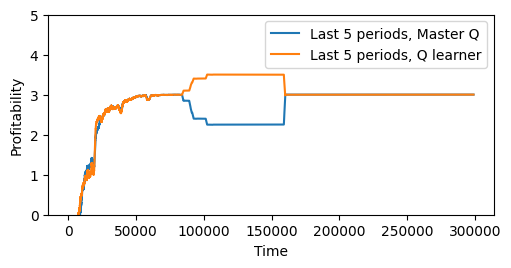

In [103]:
profitability_last1_5, profitability_last2_5 = moving_avg(last_prof1_5, last_prof2_5, 1000)
t_arr1 = np.arange(0,298999)
t_arr2 = np.arange(0,298999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_last1_5,'-',label='Last 5 periods, Master Q')
plt.plot(t_arr2,profitability_last2_5,'-', label='Last 5 periods, Q learner')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
plt.ylim(0.00,5)
plt.legend()
plt.show()

# EXPERIMENTS WITH THETA EXPLORATION #

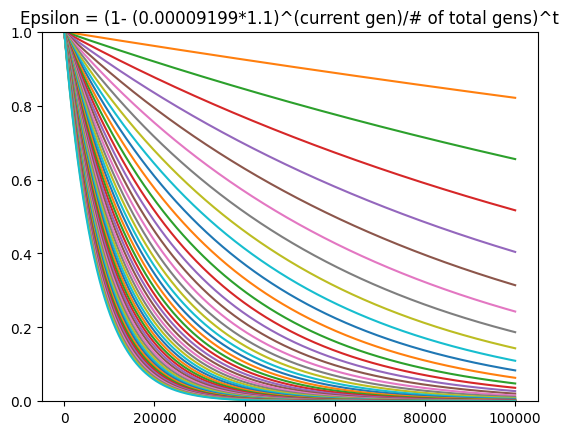

In [31]:
arr = np.zeros(100000)
t = np.arange(0,100000,1)
# def master_epsilon(theta,i,lean):
#     theta*(i**2/)
for j in range(0,100,2):
    for i in range(100000):
        arr[i] = (1-(0.00009199*(j**1.1)/100))**i
    plt.plot(t,arr,'-',label=f"gen{j}")
plt.title("Epsilon = (1- (0.00009199*1.1)^(current gen)/# of total gens)^t")
#plt.legend()
plt.ylim(0,1)
plt.show()

# arr = np.zeros(1000)
# t = np.arange(0,1000,1)
# # def master_epsilon(theta,i,lean):
# #     theta*(i**2/)
# for j in range(0,1000,2):
#     for i in range(1000):
#         arr[i] = (1-(0.0092*(j**1.25)/1000))**i

#     plt.plot(t,arr,'-',label='generational Q_learner')

# plt.ylim(0,1)
# plt.show()

# arr = np.zeros(2000000)
# t = np.arange(0,1000,1)
# # def master_epsilon(theta,i,lean):
# #     theta*(i**2/)
# for j in range(0,1000,2):
#     for i in range(1000):
#         arr[i] = (1-(0.0092*(j**1.25)/1000))**i

#     plt.plot(t,arr,'-',label='generational Q_learner')

# plt.ylim(0,1)
# plt.show()

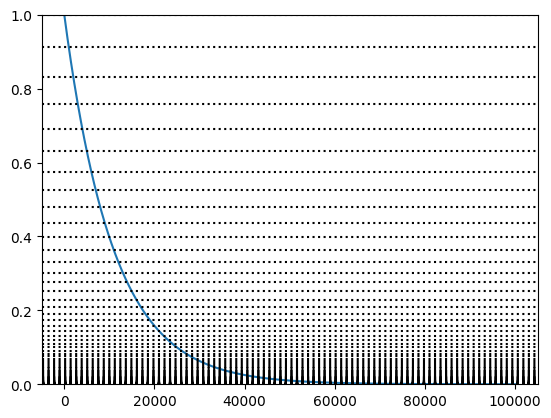

In [32]:
arr = np.zeros(100000)
t = np.arange(0,100000,1)
for i in range(100000):
    arr[i] = epsilon = (1-0.0000922)**i

arr2 = np.zeros(100)
t2 = np.arange(0,100,1)
for i in range(100):
    arr2[i] = epsilon = (1-0.087988)**i



plt.plot(t,arr,'-',label='generational Q_learner')
for i in arr2:
    plt.axhline(y=i, color='k', linestyle = 'dotted')
plt.ylim(0,1)
plt.show()


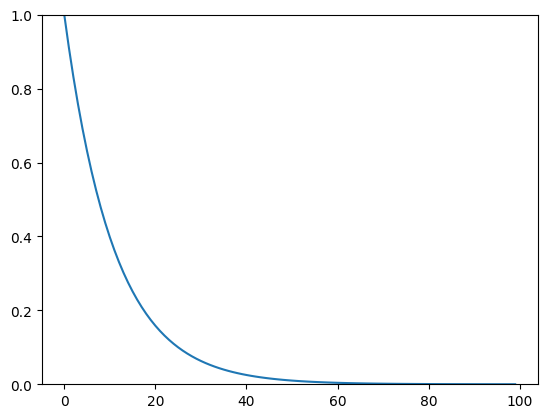

In [105]:
arr = np.zeros(100)
t = np.arange(0,100,1)
for i in range(100):
    arr[i] = epsilon = (1-0.087988)**i
plt.plot(t,arr,'-',label='generational Q_learner')
plt.ylim(0,1)
plt.show()